# Perform LDA using custom functions as well as using sklearn libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets

In [2]:
iris_data = datasets.load_iris()

In [3]:
iris_df = pd.DataFrame(data=(iris_data).data,columns=iris_data.feature_names)

In [4]:
iris_df["target"] = iris_data.target
iris_df["target_names"] = iris_df["target"].map({0:"setosa",1:"versicolor",2:"virginica"})

In [5]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [6]:
feature_names = iris_data.feature_names
target_names = iris_data.target_names

## Step 1: Computing the d-dimensional mean vectors

In [7]:
def compute_mean_vectors(df,feature_names,target_names):
    mean_vectors = []
    for i in range(len(target_names)):
        mean_class = df[df.target_names == target_names[i]][feature_names].mean()
        mean_vectors.append(mean_class)
    return mean_vectors

In [8]:
mean_vectors = compute_mean_vectors(iris_df,feature_names,target_names)

## Step 2: Computing the scatter matrices
## SW = S1+S2+S3

In [9]:
def compute_covariance_matrix(matrix):
    N = len(matrix)
    cov_mat = (np.dot(matrix.T,matrix))/N
    return cov_mat

In [10]:
# define the covariance matrix as zeros and add the cov matrix of each class
# shape of the sw should be equal to the (no of features * no of features)

def compute_withinclass_scatter(df,feature_names,target_names):
    sw = np.zeros((len(feature_names),len(feature_names)))
    for class_name,mean_vector in list(zip(target_names,mean_vectors)):
        diff_matrix = df[df.target_names == class_name][feature_names]-mean_vector
        cov_matrix = compute_covariance_matrix(diff_matrix)
        sw = sw+cov_matrix
    return sw

In [11]:
sw = compute_withinclass_scatter(iris_df,feature_names,target_names)
print("Within class scatter matrix SW:\n")
print(sw)

Within class scatter matrix SW:

[[0.779124 0.2726   0.492492 0.1129  ]
 [0.2726   0.33924  0.162416 0.096168]
 [0.492492 0.162416 0.544452 0.125436]
 [0.1129   0.096168 0.125436 0.123132]]


## Step3: Calculating the between class scatter matrix SB

In [12]:
def compute_between_class_scatter(df,feature_names,target_names):
    grand_mean = df[feature_names].mean()
    grand_mean = np.array(grand_mean).reshape(-1,1)
    
    #initialise the sb with zeros of the shape 4*4 as we have 4 features
    sb = np.zeros((len(feature_names),len(feature_names)))
    
    for i,mean_vector in enumerate(mean_vectors):
        mean_vector = np.array(mean_vector).reshape(-1,1)
        sb = sb+np.dot((mean_vector-grand_mean),(mean_vector-grand_mean).T)
    return sb

In [13]:
sb = compute_between_class_scatter(iris_df,feature_names,target_names)
print("Within class scatter matrix SB:\n")
print(sb)

Within class scatter matrix SB:

[[ 1.26424267 -0.39905333  3.304968    1.42558667]
 [-0.39905333  0.22689867 -1.144792   -0.45865333]
 [ 3.304968   -1.144792    8.742056    3.73548   ]
 [ 1.42558667 -0.45865333  3.73548     1.60826667]]


## Step 3: Solving the eigenvalue for the matrix  SW_inv * SB

In [14]:
def compute_eig(matrix):
    eig_val,eig_vec = np.linalg.eig(matrix)
    return eig_val,eig_vec

In [15]:
sw_inv_dot_sb = np.dot(np.linalg.inv(sw),sb)
eigen_values,eigen_vectors = compute_eig(sw_inv_dot_sb)

In [16]:
for i in range(len(eigen_values)):
    print("Eigen Value",str(i+1),":",eigen_values[i].real)
    print("Eigen Vector",str(i+1),":\n",(eigen_vectors[:,i].real).reshape(4,1))

Eigen Value 1 : 32.19192919827803
Eigen Vector 1 :
 [[-0.20874182]
 [-0.38620369]
 [ 0.55401172]
 [ 0.7073504 ]]
Eigen Value 2 : 0.28539104262307446
Eigen Vector 2 :
 [[-0.00653196]
 [-0.58661055]
 [ 0.25256154]
 [-0.76945309]]
Eigen Value 3 : -1.2633716995678718e-15
Eigen Vector 3 :
 [[-0.7221564 ]
 [ 0.28623358]
 [ 0.27787859]
 [ 0.07633598]]
Eigen Value 4 : -1.2633716995678718e-15
Eigen Vector 4 :
 [[-0.7221564 ]
 [ 0.28623358]
 [ 0.27787859]
 [ 0.07633598]]


In [17]:
#testing if sw_inv*sb*eigenvectors = eigen_values*eigenvector
#Raises an AssertionError if two objects are not equal up to desired precision.

In [18]:
for i in range(len(eigen_values)):
    eigv = eigen_vectors[:,i].reshape(4,1)
    
    vec_a = np.linalg.inv(sw).dot(sb).dot(eigv) #sw_inv * sb * eig_vec
    vec_b = eigen_values[i] * eigv              #eig_val * eig_vec
    
    np.testing.assert_array_almost_equal(vec_a,vec_b,decimal=6, err_msg='', verbose=True)
print('Test passed')
print('sw_inv * sb * eig_vector = eig_value * eig_vector')

Test passed
sw_inv * sb * eig_vector = eig_value * eig_vector


In [19]:
## Sort the eigen values by the decreasing order
indexes = np.argsort(eigen_values)[::-1]
eigen_vals =eigen_values[indexes]
eigen_vectors =eigen_vectors[:,indexes]

In [20]:
#Percentage variance explained by each eigen vector
for i in range(len(eigen_vals)):
    print("Percentage varience explained by eigen vector",str(i+1),":", np.round((eigen_vals[i]/sum(eigen_vals)).real*100,2))

Percentage varience explained by eigen vector 1 : 99.12
Percentage varience explained by eigen vector 2 : 0.88
Percentage varience explained by eigen vector 3 : -0.0
Percentage varience explained by eigen vector 4 : -0.0


In [21]:
#showing that each eigen vector is a unit vector
for i in range(len(eigen_vals)):
    print("Length of Eigen vector",str(i+1),":",np.linalg.norm(eigen_vectors[:,i]))

Length of Eigen vector 1 : 1.0
Length of Eigen vector 2 : 1.0
Length of Eigen vector 3 : 0.9999999999999997
Length of Eigen vector 4 : 0.9999999999999997


## Since top 2 eigen vectors explain the variance we shall select those 2

In [22]:
#example of hstack
A = np.array([1,2])
B = np.array([22,45])
temp = np.hstack((A.reshape(2,1),B.reshape(2,1)))
temp

array([[ 1, 22],
       [ 2, 45]])

In [23]:
#Stack arrays in sequence horizontally (column wise).
#stack the eigen vector1 and eigen vecotr2 horizontally
W = np.hstack((eigen_vectors[:,0].reshape(4,1),eigen_vectors[:,1].reshape(4,1)))
W

array([[-0.20874182+0.j, -0.00653196+0.j],
       [-0.38620369+0.j, -0.58661055+0.j],
       [ 0.55401172+0.j,  0.25256154+0.j],
       [ 0.7073504 +0.j, -0.76945309+0.j]])

In [24]:
#or we can choose W = eigen_vectors[:,:2]

## Step 5: Transforming the data onto the new subspace

> Y = X * W
> X = 150*4
> W = 4*2 

> so Y will be 150*2

In [25]:
X_lda = np.dot(iris_df[feature_names],W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

### Plotting

In [26]:
from matplotlib import pyplot as plt

def plot_lda_pca(x_transformed,option='LDA'):
    
    
        for target,marker,color in zip(range(0,3),('^', 's', 'o'),('blue', 'red', 'green')):

            plt.scatter(
                    x=x_transformed[:,0].real[iris_df['target'] == target], #taking the LD1 values corresponding to target on x axis
                    y=x_transformed[:,1].real[iris_df['target'] == target], #taking the LD2 values corresponding to target on y axis
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=feature_names[target]
                    )
            if option == 'LDA':

                plt.xlabel('LD1')
                plt.ylabel('LD2')
                plt.legend(loc='upper right', fancybox=True)
                plt.title('LDA: Iris projection onto the first 2 linear discriminants')
                plt.grid()
                plt.tight_layout
        
            elif option == 'PCA':
                plt.xlabel('PC1')
                plt.ylabel('PC2')
                plt.legend(loc='upper right', fancybox=True)
                plt.title('PCA: Iris projection onto the first 2 pricipal components')
                plt.grid()
                plt.tight_layout
            else:
                return "Pass correct option"

In [27]:
## perform the PCA on the data and comapre with LDA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(iris_df[feature_names])
print("Explained variance by the PC1 and PC2 respectively")
print(pca.explained_variance_ratio_)

Explained variance by the PC1 and PC2 respectively
[0.92461872 0.05306648]


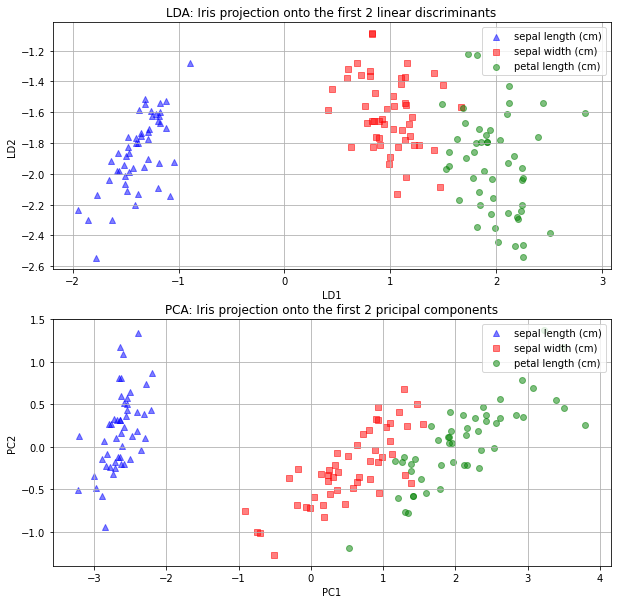

In [28]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plot_lda_pca(X_lda,"LDA")
plt.subplot(2,1,2)
plot_lda_pca(x_pca,"PCA")

## Inference:
The LDA performs betters in terms of separating the classes
The PCA tries to capture maximum variation in data

In [29]:
## LDA using the sklearn library

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda_sklearn = lda.fit_transform(iris_df[feature_names], iris_df['target'])

In [31]:
lda.explained_variance_ratio_

array([0.9912126, 0.0087874])

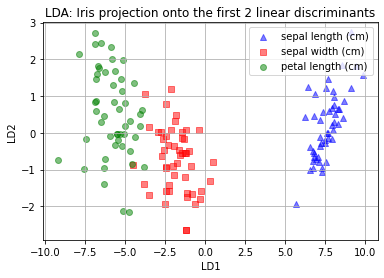

In [32]:
plot_lda_pca(X_lda_sklearn,"LDA")

In [33]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_std = sc.fit_transform(iris_df[feature_names])

In [34]:
X_lda_sklearn2 = lda.fit_transform(x_std, iris_df['target'])

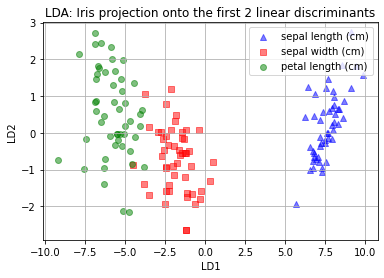

In [35]:
plot_lda_pca(X_lda_sklearn2,"LDA")

In [36]:
X_pca_sklearn = pca.fit_transform(x_std, iris_df['target'])

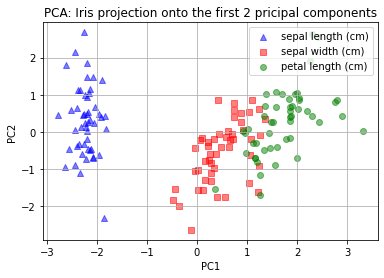

In [37]:
plot_lda_pca(X_pca_sklearn,"PCA")